# About notebook:
* What I concretely have this far on using bokeh for interactive map

Todo:

* Add hover ("mouse hold over" that we can add information to)
*  Implement "Africa geoplot shapefile" to enable visualization of statistics per country 
  * (e.g. like this example for Texas: http://bokeh.pydata.org/en/latest/docs/gallery/texas.html)
* Dynamic slider?
* Connecting plots?

# Imports

In [1]:
import pandas as pd
import numpy as np
import datetime

%matplotlib inline

## Importing ACLED data

In [2]:
folder = 'data'
file = 'ACLED-Version-7-All-Africa-1997-2016_csv_dyadic-file.zip'

Importing using pd.read_csv (reading the csv directly from zip file)

**Note:** Using

* encoding='latin_1' because utf encoding resulted in error (non-utf characters in data)
* low_memory=True due to warning of mixed data type in some columns (17,19,20)

In [3]:
df = pd.read_csv(folder+'/'+file, encoding='latin_1', low_memory=False)

## Pre-processing

### Remove NA columns
Remove columns with **no** data (there are 11 of them in the file):

In [4]:
df = df.dropna(axis=1, how='all')

### Convert 'EVENT_DATE' to datetime

In [5]:
def datetime_dmy(datetimestring):
    # Returns datetime object from string on format dd/mm/yyyy
    return datetime.datetime.strptime(datetimestring,
                                      '%d/%m/%Y')

df['EVENT_DATE'] = df['EVENT_DATE'].apply(datetime_dmy)

In [6]:
# Checking that all went well
print(type(df['EVENT_DATE'][0]))
print(df['EVENT_DATE'][10])

<class 'pandas.tslib.Timestamp'>
1997-01-22 00:00:00


### Changing LATITUDE and LONGITUDE to floats
They are imported with dtype=object

In [7]:
print("dtype before: ", df['LATITUDE'].dtype)
df = df.astype({
    'LATITUDE': float, 'LONGITUDE': float})

print("dtype after:  ", df['LATITUDE'].dtype)

dtype before:  object
dtype after:   float64


# Minor data exploration
Inspired by Dirk's examples in lecture 13.02.

In [8]:
df_f = df[['EVENT_DATE', 'COUNTRY', 'FATALITIES']]

## Plotting fatalities

### Creating pivot table
* Important to set 'aggfunc' to sum (standard is mean)

In [9]:
df_piv = df_f.pivot_table(index='EVENT_DATE',
                              columns='COUNTRY',
                              values='FATALITIES',
                              aggfunc=np.sum)

### Resampling pivot to monthly

In [10]:
df_piv = df_piv.resample('1M').sum()

### Extract countries
Extract 5 countries with highest total fatalities (for plotting)

In [11]:
most_fat = list(df_piv.sum().sort_values(
                     ascending=False)[0:5].index)

In [12]:
print("Total number of events:")
df_piv.sum().sort_values(
                     ascending=False)[0:5]

Total number of events:


COUNTRY
Angola                          143743.0
Sudan                            84710.0
Eritrea                          79369.0
Democratic Republic of Congo     75586.0
Nigeria                          56737.0
dtype: float64

In [13]:
df_fat = df_piv[most_fat]

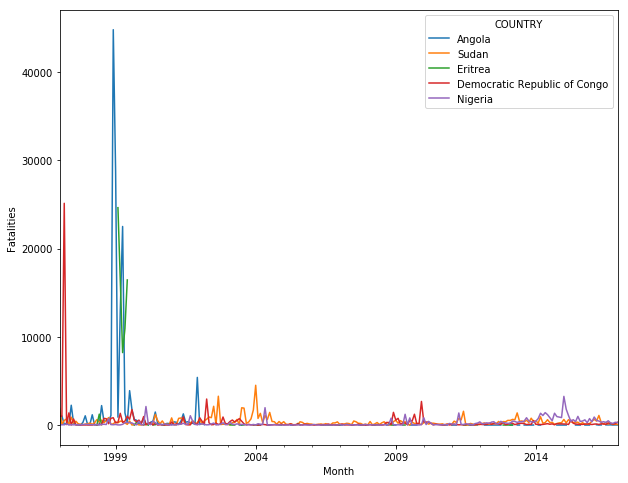

In [14]:
ax = df_fat.plot(figsize=(10,8))
ax.set_ylabel("Fatalities")
ax.set_xlabel("Month")

## Plotting using pandas
Pandas is more flexible and allows zooming ++

In [15]:
# TO BE FIXED

# Bokeh geo-plotting
Based on:
http://nbviewer.jupyter.org/github/bokeh/bokeh-notebooks/blob/master/tutorial/11%20-%20geo.ipynb

In [16]:
from bokeh.io import output_notebook, show
output_notebook()

Loading BokehJS ...

In [17]:
from bokeh.plotting import figure
from bokeh.tile_providers import WMTSTileSource

# NOTE: This is a little off Africa, but can easily be moved:
dist = 6000000
x_min = -30000
y_min = -8000000

Africa = x_range,y_range = ((-x_min,x_min+dist), (-y_min,y_min+dist))

fig = figure(tools='pan, wheel_zoom', x_range=x_range, y_range=y_range)
fig.axis.visible = False

In [18]:
url = 'http://a.basemaps.cartocdn.com/dark_all/{Z}/{X}/{Y}.png'
attribution = "Map tiles by Carto, under CC BY 3.0. Data by OpenStreetMap, under ODbL"

fig.add_tile(WMTSTileSource(url=url, attribution=attribution))

TileRenderer(id='980e7987-8530-4dec-a370-ac356c138355', ...)

In [19]:
show(fig)

## Adding some points:

In [20]:
# Function comes from tutorial (see section header):
def wgs84_to_web_mercator(df, lon="LONGITUDE", lat="LATITUDE"):
    """Converts decimal longitude/latitude to Web Mercator format"""
    k = 6378137
    df["x"] = df[lon] * (k * np.pi/180.0)
    df["y"] = np.log(np.tan((90 + df[lat]) * np.pi/360.0)) * k
    return df

Selecting nor or less random samples (statistically speaking

In [21]:
N_points = 10000

test_points = df.iloc[0:N_points][['COUNTRY','LATITUDE', 'LONGITUDE', 'FATALITIES']]

In [22]:
wgs84_to_web_mercator(test_points)

None # To surpress output from function call

#### Plotting the points from above
**Note**: Size of plot set proportional with fatalities, in a little dodgy way (for now)

In [23]:
fig.circle(x=test_points['x'], y=test_points['y'],fill_color='blue', size=4*np.log(1+test_points['FATALITIES']))
show(fig)